This is based on Gil's work: 
https://signal.onepointltd.com/post/102gc83/sentiment-analysis-with-yelp-and-bert
https://github.com/onepointconsulting/yelp_bert/blob/master/preprocess_data.ipynb

And on this one:
https://github.com/Sonull/Sentiment-Analysis-on-Yelp-Reviews/blob/master/RF_and_SVM1.ipynb

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from pathlib import Path
import json
import seaborn as sns
from collections import Counter

/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json
/kaggle/input/yelp-dataset/Dataset_Agreement.pdf


In [3]:
#business_file = '/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json'

In [ ]:
#df_business.head(5)

In [4]:
review_file = '/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json'

In [18]:
sample_size = 40000
simplified_reviews = './yelp_reviews_simple_{sample_size}.json'

def extract_simplified(source, target, lines=1000):
    with open(target, 'w') as sr:
        cnt = 0;
        with open(source) as file:
            line = file.readline()
            while line:
                cnt += 1
                if cnt == lines:
                    break
                if cnt % 100_000 == 0:
                    print(f'Processed {cnt}')
                try:
                    line = file.readline().strip()
                    review_dict = json.loads(line)
                    simplified = {'text':  review_dict['text'], 'stars': review_dict['stars']}
                    simplified_text = json.dumps(simplified)
                    sr.write(f'{simplified_text}\n')
                except:
                    print(f'Could not parse {line}')
                    
extract_simplified(review_file, simplified_reviews, lines=sample_size)

In [19]:
simplified_reviews_pd = pd.read_json(simplified_reviews, lines=True)

In [20]:
simplified_reviews_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39999 entries, 0 to 39998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    39999 non-null  object
 1   stars   39999 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [21]:
simplified_reviews_pd

,text,stars
0,I am actually horrified this place is still in...,1
1,I love Deagan's. I do. I really do. The atmosp...,5
2,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",1
3,"Oh happy day, finally have a Canes near my cas...",4
4,This is definitely my favorite fast food sub s...,5
...,...,...
39994,We stopped here after reading a Yelp review. A...,5
39995,I love this cafe! Doesn't matter what day it i...,5
39996,Finally after months of waiting the hubby and ...,5
39997,I always wanted to try a blowout service but a...,1


In [22]:
simplified_reviews_pd['stars'].value_counts()

5    17495
4     9218
1     5593
3     4445
2     3248
Name: stars, dtype: int64

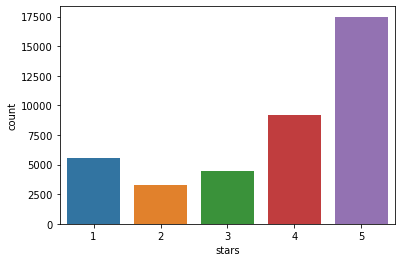

In [23]:
sns.countplot(simplified_reviews_pd['stars'])

In [24]:
counter_star = Counter(simplified_reviews_pd['stars'])

In [25]:
min_class = -1
min_amount = 1000000000
for cs in counter_star:
    if min_amount > counter_star[cs]:
        min_amount = counter_star[cs]
        min_class = cs
min_class, min_amount

(2, 3248)

In [26]:
remove_amounts = {c: abs(min_amount - counter_star[c]) for c in counter_star}
remove_amounts

{1: 2345, 5: 14247, 4: 5970, 3: 1197, 2: 0}

In [27]:
remove_amounts[1] -= 1
remove_amounts

{1: 2344, 5: 14247, 4: 5970, 3: 1197, 2: 0}

In [28]:
%%time
drop_indices = []
for index, row in simplified_reviews_pd.iterrows():
    if remove_amounts[row['stars']] > 0:
        remove_amounts[row['stars']] -= 1
        drop_indices.append(index)
len(drop_indices)

CPU times: user 3.67 s, sys: 310 µs, total: 3.67 s
Wall time: 3.67 s


23758

In [29]:
balanced_simplified_reviews = simplified_reviews_pd.drop(drop_indices)

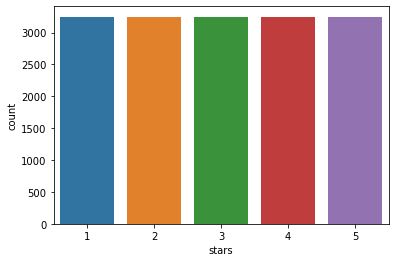

In [30]:
sns.countplot(balanced_simplified_reviews['stars'])

In [31]:
balanced_simplified_reviews['stars'].unique()

array([2, 3, 1, 4, 5])

In [32]:
# dropping reviews with 3 stars
balanced_simplified_reviews.drop(balanced_simplified_reviews.index[balanced_simplified_reviews['stars'] == 3], inplace = True)
print('yelp_reviews labels: ' + str(balanced_simplified_reviews.stars.unique()))
print('yelp_reviews shape: ' + str(balanced_simplified_reviews.shape))


yelp_reviews labels: [2 1 4 5]
yelp_reviews shape: (12993, 2)


In [33]:
# changing to only 2 labels: 0=negative, 1=positive
balanced_simplified_reviews['Label'] = balanced_simplified_reviews['stars'].replace({1:0,2:0,4:1,5:1})

In [34]:
balanced_simplified_reviews['stars'].value_counts()

1    3249
5    3248
4    3248
2    3248
Name: stars, dtype: int64

In [35]:
balanced_simplified_reviews.head()

,text,stars,Label
31,This actually used to be one of my favorite ho...,2,0
62,Decent food. Fishermen lobster or even congee ...,2,0
77,"Pros: Fun atmosphere, great for people watchin...",2,0
85,"I love bookstores, and I love to spend some ti...",2,0
86,"I passed Five Guys, In-N-Out, Carl's Jr, and S...",2,0


In [36]:
balanced_simplified_reviews.drop('stars',inplace=True,axis = 1)

In [38]:
sample_balanced_reviews = balanced_simplified_reviews.reset_index(drop=True)
sample_balanced_reviews

,text,Label
0,This actually used to be one of my favorite ho...,0
1,Decent food. Fishermen lobster or even congee ...,0
2,"Pros: Fun atmosphere, great for people watchin...",0
3,"I love bookstores, and I love to spend some ti...",0
4,"I passed Five Guys, In-N-Out, Carl's Jr, and S...",0
...,...,...
12988,We stopped here after reading a Yelp review. A...,1
12989,I love this cafe! Doesn't matter what day it i...,1
12990,Finally after months of waiting the hubby and ...,1
12991,I always wanted to try a blowout service but a...,0


In [39]:
sample_balanced_reviews.to_csv('./sample_yelp_reviews_12993.csv')

In [ ]:
from gensim.parsing.preprocessing import STOPWORDS, strip_tags, strip_numeric, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short, stem_text
from nltk.corpus import stopwords
import re

In [ ]:
for r in balanced_simplified_reviews:
    balanced_simplified_reviews['text'] = balanced_simplified_reviews['text'].apply(lambda t: strip_numeric(t))
    #balanced_simplified_reviews['text'] = balanced_simplified_reviews['text'].apply(lambda t: strip_punctuation(t))
    balanced_simplified_reviews['text'] = balanced_simplified_reviews['text'].apply(lambda t: strip_multiple_whitespaces(t))
    #balanced_simplified_reviews['text'] = balanced_simplified_reviews['text'].apply(lambda t: t.lower())
    balanced_simplified_reviews['text'] = balanced_simplified_reviews['text'].apply(lambda t: remove_stopwords(t))
    #balanced_simplified_reviews['text'] = balanced_simplified_reviews['text'].apply(lambda t: strip_short(t))

In [ ]:
balanced_simplified_reviews